In [37]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeClassifier
from clingo.control import Control
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

np.random.seed(42)

In [2]:
def tree_to_cnf(tree, feature_names):
    tree = tree.tree_
    positive_clauses = []
    negative_clauses = []
    var_mapping = {}
    var_counter = [1]  # Mutable counter

    def fresh_var():
        name = f'p{var_counter[0]}'
        var_counter[0] += 1
        return name

    def traverse(node, path):
        if tree.feature[node] == _tree.TREE_UNDEFINED:
            if tree.value[node][0, 1] > tree.value[node][0, 0]:
                positive_clauses.append(path)
            else:
                negative_clauses.append(path)
        else:
            feature_index = tree.feature[node]
            threshold = round(tree.threshold[node], 4)
            feature = feature_names[feature_index]

            # Search for an existing variable with the same [feature, threshold]
            existing_var = None
            for var, pair in var_mapping.items():
                if pair == [feature, threshold]:
                    existing_var = var
                    break

            if existing_var is not None:
                var = existing_var  # Reuse the existing variable
            else:
                var = fresh_var()
                var_mapping[var] = [feature, threshold]

            # Left: feature <= threshold  → -var
            traverse(
                tree.children_left[node],
                path + [f'-{var}']
            )

            # Right: feature > threshold → var
            traverse(
                tree.children_right[node],
                path + [var]
            )

    # Start traversal from root
    traverse(0, [])

    # Construct CNF formulas
    cnf_formula_neg = ' & '.join([' | '.join(clause) for clause in negative_clauses])
    cnf_formula_pos = ' & '.join([' | '.join(clause) for clause in positive_clauses])

    return {
        'positive_cnf': cnf_formula_pos,
        'negative_cnf': cnf_formula_neg,
        'var_mapping': var_mapping
    }

In [3]:
ENC = {
    "GLOBAL_CE" : "prototype/enc_def3.lp",
    "CF_CE"     : "prototype/enc_def5.lp",
    "CF_DIFF"   : "prototype/enc_def6.lp"
}

def __parse_cnf(str):
    cnf = []
    for str_cl in str.split("&"):
        cl = []
        for str_lit in str_cl.split("|"):
            s = str_lit.strip()
            if s.startswith('-'):
                cl.append((s[1:],False))
            else:
                cl.append((s,True))
        cnf.append(cl)
    
    return cnf

def __cnf_to_facts(instance_cnf,fact_cnf,foil_cnf):
    facts = []
    i = 1
    for cl in instance_cnf:
        facts.append(f"instance_cl({i}).")
        for l,t in cl:
            sign = "t" if t else "f"
            facts.append(f"lit({i},{l},{sign}).")
        i += 1
    for cl in fact_cnf:
        facts.append(f"fact_cl({i}).")
        for l,t in cl:
            sign = "t" if t else "f"
            facts.append(f"lit({i},{l},{sign}).")
        i += 1
    for cl in foil_cnf:
        facts.append(f"foil_cl({i}).")
        for l,t in cl:
            sign = "t" if t else "f"
            facts.append(f"lit({i},{l},{sign}).")
        i += 1
        
    return facts


def __cnf_to_str(cnf):
    cl_str = []
    for cl in cnf:
        parse_lit = lambda l,s: l if s else f"-{l}" 
        cl_str.append(" | ".join([ parse_lit(l,s) for l,s in cl ]))
    
    return "  &  ".join(cl_str)


def __parse_answer_set(answer_set):
    theta = {}
    theta_p = {}
    chi = {}
    for sym in answer_set.symbols(shown=True):
        if sym.match('theta_lit',3):
            c = sym.arguments[0].number
            l = str(sym.arguments[1])
            s = str(sym.arguments[2])

            if c not in theta:
                theta[c] = []
            theta[c].append((l,s == "t"))
        elif sym.match('theta_p_lit',3):
            c = sym.arguments[0].number
            l = str(sym.arguments[1])
            s = str(sym.arguments[2])

            if c not in theta_p:
                theta_p[c] = []
            theta_p[c].append((l,s == "t"))
        elif sym.match('chi_lit',3):
            c = sym.arguments[0].number
            l = str(sym.arguments[1])
            s = str(sym.arguments[2])

            if c not in chi:
                chi[c] = []
            chi[c].append((l,s == "t"))

    
    return (list(dict(sorted(theta.items())).values()), 
            list(dict(sorted(theta_p.items())).values()), 
            list(dict(sorted(chi.items())).values()))


def __clingo_solve(encoding, n_models=1, max_clauses=5, max_lits=1):
    ctl = Control(['-Wnone', '--opt-mode=optN', '-t8', f'-c n_clauses={max_clauses}' , f'-c n_lits={max_lits}', '--verbose'])
    ctl.add(encoding)
    ctl.ground([("base", [])])
    answer_set = None
    cost = None
    opt_models = 0
    def on_model(model):
        nonlocal answer_set, cost, opt_models
        prev_cost = cost
        cost = model.cost
        if prev_cost == cost:
            opt_models += 1
            theta, theta_p, chi  = __parse_answer_set(model)
            answer_set = theta, theta_p, chi
            print(f"SOLUTION (cost {cost}):")
            print("Theta:")
            print(__cnf_to_str(theta))
            print("Theta':")
            print(__cnf_to_str(theta_p))
            print("Chi:")
            print(__cnf_to_str(chi))
            print()

        if n_models > 0 and opt_models >= n_models:
            ctl.interrupt()
        
    ctl.solve(on_model=on_model)

    return answer_set

In [4]:
# Load Breast Cancer dataset
breast_cancer = load_breast_cancer()
df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)

# Remove spaces in feature names
df.columns = df.columns.str.replace(' ', '')

# 1. Dataset

df['target'] = breast_cancer.target
X = df.drop(columns = ['target'], axis = 1)
y = df['target']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Train a model.

model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9473684210526315


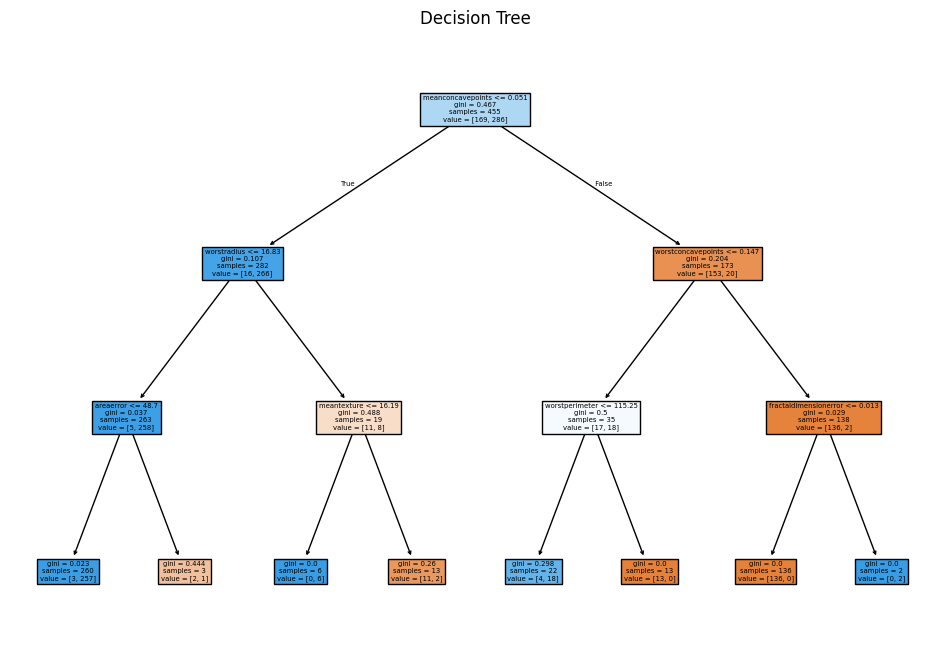

In [6]:
# Assuming model has been trained already, as per the given code
plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, feature_names=X_train.columns)
plt.title("Decision Tree")
plt.show()

In [7]:
output = tree_to_cnf(model, X.columns)
cnf1 = output['negative_cnf']
cnf2 = output['positive_cnf']
var_map = output['var_mapping']
fact = __parse_cnf(cnf1)
foil = __parse_cnf(cnf2)
print(f'Fact: {cnf1}')
print(f'Foil: {cnf2}')
print()

Fact: -p1 | -p2 | p3 & -p1 | p2 | p4 & p1 | -p5 | p6 & p1 | p5 | -p7
Foil: -p1 | -p2 | -p3 & -p1 | p2 | -p4 & p1 | -p5 | -p6 & p1 | p5 | p7



In [8]:
for key, (feature, threshold) in var_map.items():
    print(f'{key}: {feature} <= {threshold}')

p1: meanconcavepoints <= 0.0513
p2: worstradius <= 16.83
p3: areaerror <= 48.7
p4: meantexture <= 16.19
p5: worstconcavepoints <= 0.1465
p6: worstperimeter <= 115.25
p7: fractaldimensionerror <= 0.0129


In [9]:
def evaluate_instance_against_vars(instance_as_dict, var_mapping):
    result = {}
    for var, (feature, threshold) in var_mapping.items():
        result[var] = instance_as_dict[feature] <= threshold
    return result

# Compute explanations for positive predictions.
index = np.random.choice(np.where(y_pred == 1)[0])
instance = str()
instance_as_dict = evaluate_instance_against_vars(X_test.iloc[index].to_dict(), var_map)
for j in range(len(instance_as_dict.keys())):
    key = list(instance_as_dict.keys())[j]
    if j > 0:
        instance += ' & '
    if instance_as_dict[key] == 0:
        instance += f'-{key}'
    else:
        instance += f'{key}'
print(f'Instance: {instance}')
_instance = __parse_cnf(instance)
print(f'Prediction: {y_pred[index]}')

Instance: p1 & p2 & p3 & -p4 & p5 & p6 & p7
Prediction: 1


In [10]:
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 7)
print()

SOLUTION (cost [4, -2]):
Theta:
p3
Theta':
-p3
Chi:
p2  &  p1




In [11]:
'''
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_DIFF'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 7)
print()
'''

"\nencoding = ''.join(__cnf_to_facts(_instance,fact,foil))\nwith open(ENC['CF_DIFF'], 'r') as f:\n    encoding += f.read()\n__clingo_solve(encoding, max_clauses = 7)\nprint()\n"

In [ ]:
# Load spambase
dataset = openml.datasets.get_dataset(31)
X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
y_mapped = y.map({'good': 0, 'bad': 1})

# 3. Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number", "float", "int"]).columns.tolist()

# 4. Create the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # keep numerical columns
)

# 5. Apply transform to X directly
X_transformed = preprocessor.fit_transform(X)

# 6. Optional: get feature names
ohe = preprocessor.named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(encoded_feature_names) + numerical_cols

# 7. Convert to DataFrame (optional)
X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y_mapped, test_size=0.2, random_state=42)

     checking_status_0<=X<200  checking_status_<0  checking_status_>=200  \
0                         0.0                 1.0                    0.0   
1                         1.0                 0.0                    0.0   
2                         0.0                 0.0                    0.0   
3                         0.0                 1.0                    0.0   
4                         0.0                 1.0                    0.0   
..                        ...                 ...                    ...   
995                       0.0                 0.0                    0.0   
996                       0.0                 1.0                    0.0   
997                       0.0                 0.0                    0.0   
998                       0.0                 1.0                    0.0   
999                       1.0                 0.0                    0.0   

     checking_status_no checking  credit_history_all paid  \
0                         

In [47]:
# Train a model.

model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.775


In [49]:
output = tree_to_cnf(model, X_transformed_df.columns)
cnf1 = output['negative_cnf']
cnf2 = output['positive_cnf']
var_map = output['var_mapping']
fact = __parse_cnf(cnf1)
foil = __parse_cnf(cnf2)
print(f'Fact: {cnf1}')
print(f'Foil: {cnf2}')
print()

Fact: -p1 | -p2 | -p3 & -p1 | p2 | -p4 & p1 | -p5 | -p6 & p1 | -p5 | p6 & p1 | p5 | -p7 & p1 | p5 | p7
Foil: -p1 | -p2 | p3 & -p1 | p2 | p4



In [50]:
for key, (feature, threshold) in var_map.items():
    print(f'{key}: {feature} <= {threshold}')

p1: checking_status_no checking <= 0.5
p2: duration <= 22.5
p3: credit_history_all paid <= 0.5
p4: savings_status_<100 <= 0.5
p5: other_payment_plans_none <= 0.5
p6: purpose_radio/tv <= 0.5
p7: age <= 31.5


In [75]:
def evaluate_instance_against_vars(instance_as_dict, var_mapping):
    result = {}
    for var, (feature, threshold) in var_mapping.items():
        result[var] = instance_as_dict[feature] <= threshold
    return result

# Compute explanations for positive predictions.
index = np.random.choice(np.where(y_pred == 1)[0])
instance = str()
instance_as_dict = evaluate_instance_against_vars(X_test.iloc[index].to_dict(), var_map)
for j in range(len(instance_as_dict.keys())):
    key = list(instance_as_dict.keys())[j]
    if j > 0:
        instance += ' & '
    if instance_as_dict[key] == 0:
        instance += f'-{key}'
    else:
        instance += f'{key}'
print(f'Instance: {instance}')
_instance = __parse_cnf(instance)
print(f'Prediction: {y_pred[index]}')

Instance: p1 & -p2 & p3 & -p4 & -p5 & p6 & -p7
Prediction: 1


In [76]:
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 7)
print()

SOLUTION (cost [4, -2]):
Theta:
-p4
Theta':
p4
Chi:
-p2  &  p1


